In [1]:
from aiida import orm, load_profile
load_profile()

from aiida_atomistic.data.structure import StructureData

import numpy as np
import matplotlib.pyplot as plt


# Performance test atomistic.StructureData vs orm.StructureData

- Increase linearly the number of atoms in both cases(2D plot), 
- Then see how the scaling changes if I also defined more and more related properties (2D countour plot?)

In [2]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }

In [3]:
structure = StructureData(properties = properties)

In [4]:
structure.properties.get_stored_properties()

['symbols', 'pbc', 'positions', 'cell', 'mass']

In [5]:
legacy = orm.StructureData(cell=properties['cell']['value'])
for position,symbol in list(zip(properties['positions']['value'],properties['symbols']['value'])):
    legacy.append_atom(position=position,symbols=symbol)

## Test 1. only increasing number of atoms.

In [53]:
def generate_simple_atomistic(properties):
    return StructureData(properties = properties)

def generate_simple_orm(cell, zipped):
    legacy = orm.StructureData(cell=cell)
    for position,symbol in zipped:
        legacy.append_atom(position=position,symbols=symbol)
    
    return legacy

def timing_atomistic_and_orm(properties, factor_list=[1]):
    """
    timing function for the generation of atomistic and orm StructureData
    without considering additional properties apart cell, positions, symbols
    """
    import time
    time_list_atom = []
    time_list_orm = []
    cell = properties['cell']['value']
    initial_pos = [[1,1,1]]
    initial_symb = ['H']
    
    for factor in factor_list:
        properties['positions']['value']=initial_pos*factor
        properties['symbols']['value']=initial_symb*factor
        zipped = list(zip(properties['positions']['value'],properties['symbols']['value']))

        t_i_atom=time.time()
        atomistic = generate_simple_atomistic(properties)
        t_f_atom=time.time()
        time.sleep(0.0001)
        t_i_orm=time.time()
        legacy = generate_simple_orm(cell, zipped) 
        t_f_orm=time.time()
        time_list_atom.append(t_f_atom-t_i_atom)
        time_list_orm.append(t_f_orm-t_i_orm)
        
        properties['positions']['value']=initial_pos
        properties['symbols']['value']=initial_symb
    
    return np.array(time_list_atom),np.array(time_list_orm),np.array(factor_list)

In [54]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }
t_atom, t_orm, factors = timing_atomistic_and_orm(properties,factor_list=list(range(1,501)))
#print(t_atom, t_orm, factors)

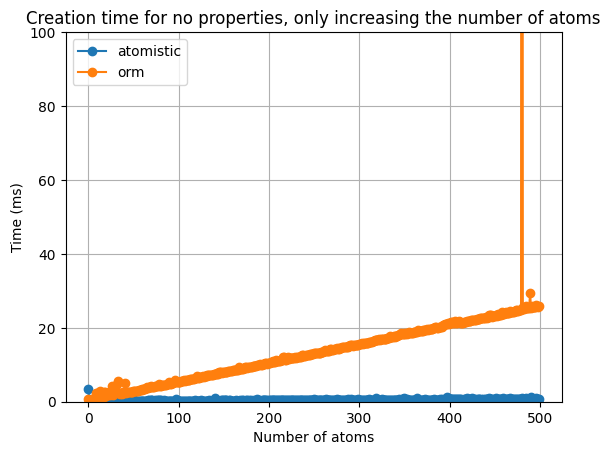

In [56]:
plt.plot(t_atom*1000, label='atomistic', marker='o')
plt.plot(t_orm*1000, label='orm', marker='o')
plt.grid()
plt.ylim(0,100)
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time for no properties, only increasing the number of atoms')
plt.legend()

In [57]:
properties

{'cell': {'value': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]},
 'positions': {'value': [[1, 1, 1]]},
 'symbols': {'value': ['H']}}

## Test 2. Adding properties and increasing number of atoms.

In [58]:
def timing_atomistic_and_orm_properties(properties, factor_list=[1], props_num=2):
    """
    timing function for the generation of atomistic and orm StructureData
    considering additional properties and additional atoms.
    """
    import time
    time_list_atom = []
    time_list_orm = []
    cell = properties['cell']['value']
    initial_pos = [[1,1,1]]
    initial_symb = ['H']
    initial_charge = [1]
    initial_mass = [1]
    initial_kinds = ['H1']
        
    for factor in factor_list:
        properties['positions']['value']=initial_pos*factor
        properties['symbols']['value']=initial_symb*factor
        properties['charge']= {'value':initial_charge*factor}
        properties['mass']= {'value':initial_mass*factor}
        properties['kinds']= {'value':initial_kinds*factor}
        
        if props_num==1: 
            properties.pop('kinds')
            properties.pop('mass')
            
        elif props_num==3:
            properties.pop('kinds')
            #properties.pop('charge')
            
        elif props_num==4:
            #properties.pop('kinds')
            properties.pop('charge')
        
        zipped = list(zip(properties['positions']['value'],properties['symbols']['value']))
        

        t_i_atom=time.time()
        atomistic = generate_simple_atomistic(properties)
        t_f_atom=time.time()
        time.sleep(0.0001)
        t_i_orm=time.time()
        legacy = generate_simple_orm(cell, zipped) 
        t_f_orm=time.time()
        time_list_atom.append(t_f_atom-t_i_atom)
        time_list_orm.append(t_f_orm-t_i_orm)
        
        properties['positions']['value']=initial_pos
        properties['symbols']['value']=initial_symb
        properties['charge']= {'value':initial_charge}
        properties['mass']= {'value':initial_mass}
        properties['kinds']= {'value':initial_kinds}
    
    return np.array(time_list_atom),np.array(time_list_orm),np.array(factor_list)

In [59]:
properties = {
    "cell":{"value":[[1,0,0],[0,1,0],[0,0,1]]},
    "positions":{"value":[[1,1,1]]},
    "symbols":{"value":["He"]},
    }
t_atom_props, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501))) # charge, mass, and kinds check
#t_atom_props_2, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501)),props_num=1) # charge, automatic masses and no kinds check
t_atom_props_3, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501)),props_num=3) # no kinds check, but charge and masses
t_atom_props_4, t_orm_props, factors = timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501)),props_num=4) # no charge, but mass and kinds check

#print(t_atom, t_orm, factors)

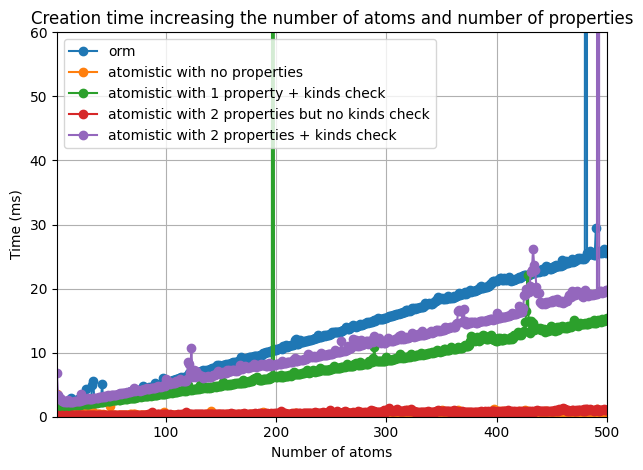

In [65]:

plt.plot(factors,t_orm*1000, label='orm', marker='o')
plt.plot(factors,t_atom*1000, label='atomistic with no properties', marker='o')
plt.plot(factors,t_atom_props_4*1000, label='atomistic with 1 property + kinds check', marker='o')
plt.plot(factors,t_atom_props_3*1000, label='atomistic with 2 properties but no kinds check', marker='o')
plt.plot(factors,t_atom_props*1000, label='atomistic with 2 properties + kinds check', marker='o')
#plt.plot(t_atom_props_2*1000, label='atomistic with charge, automatic masses and no kinds check', marker='o')
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time increasing the number of atoms and number of properties')
plt.grid()
plt.xlim(1,500)
plt.ylim(0,60)
plt.legend()
plt.tight_layout()
plt.savefig('scaling.png')

The main difference is that to create the orm.StructureData we need to loop and append atoms.

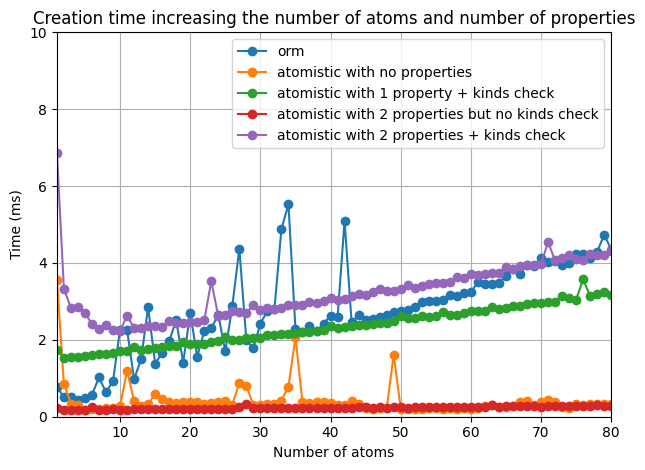

In [67]:

plt.plot(factors,t_orm*1000, label='orm', marker='o')
plt.plot(factors,t_atom*1000, label='atomistic with no properties', marker='o')
plt.plot(factors,t_atom_props_4*1000, label='atomistic with 1 property + kinds check', marker='o')
plt.plot(factors,t_atom_props_3*1000, label='atomistic with 2 properties but no kinds check', marker='o')
plt.plot(factors,t_atom_props*1000, label='atomistic with 2 properties + kinds check', marker='o')
#plt.plot(t_atom_props_2*1000, label='atomistic with charge, automatic masses and no kinds check', marker='o')
plt.ylabel('Time (ms)')
plt.xlabel('Number of atoms')
plt.title('Creation time increasing the number of atoms and number of properties')
plt.grid()
plt.xlim(1,80)
plt.ylim(0,10)
plt.legend()
plt.tight_layout()

### Comments:

- The kinds check introduce additional steps, because the get_kinds method has a loop on the number of properties. So this should scale with them. 
- Seems anyway that adding a property (from 1 to 2, both with kinds check) is not a linear scaling, but lower. This is good. 
- Without the kinds check, we have not increasing of time for increasing number of properties. And it is way faster than orm.

## Specific profiling

Read this: https://realpython.com/python-profiling/

In [51]:
import cProfile
import re
cProfile.run('timing_atomistic_and_orm_properties(properties,factor_list=list(range(1,501)))')

         81763777 function calls (73968297 primitive calls) in 29.377 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.014    0.014   29.357   29.357 1872568501.py:1(timing_atomistic_and_orm_properties)
      403    0.001    0.000   13.359    0.033 4095775007.py:1(generate_simple_atomistic)
      403    0.065    0.000   15.960    0.040 4095775007.py:4(generate_simple_orm)
   209937    0.059    0.000    0.113    0.000 <frozen abc>:117(__instancecheck__)
        2    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
     1617    0.002    0.000    0.003    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000   29.357   29.357 <string>:1(<module>)
      806    0.002    0.000    0.126    0.000 <string>:1(__init__)
      806    0.000    0.000    0.000    0.000 <string>:1(set)
    47554    0.007    0.000    0.007    0.000 __init__.py:106(get_property_attribute)
   

KeyboardInterrupt: 